<a href="https://colab.research.google.com/github/Nastarii/PCB-defect-detection/blob/main/IC_PCB_COTA_21_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload data in Colab

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --no-check-certificate \
    "https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip" \
    -O "/tmp/DeepPCB.zip"

--2022-07-24 12:50:47--  https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master [following]
--2022-07-24 12:50:47--  https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/DeepPCB.zip’

/tmp/DeepPCB.zip        [        <=>         ]  86.79M  17.0MB/s    in 5.1s    

2022-07-24 12:50:52 (16.9 MB/s) - ‘/tmp/DeepPCB.zip’ saved [91004517]



## Extract from zip

In [ ]:
!unzip -qq /tmp/DeepPCB
!unzip -qq /content/drive/MyDrive/pcb_huang_wei.zip

# Standardize data

In [ ]:
from torch.utils.data import Dataset, DataLoader
from pandas.core.frame import DataFrame
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import torch
import json
import glob
import cv2 as cv

class DatasetPCB(Dataset):

    columns_name:tuple = ('test_image_path','temp_image_path', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax')
    settings:dict = json.load(open('/content/drive/MyDrive/settings.json'))
    root:str  = '/content/'

    def __init__(self, size:int, split_size:int, buffer:DataFrame, transforms= None) -> None:
        self.new_w, self.new_h = (size,size)
        self.split_size = split_size
        self.transforms = transforms

        if buffer is None:
            self.annotations = self.samples()
        else:
            self.annotations = buffer

        self.split_data()


    def __getitem__(self, index):

        image_path = self.annotations['test_image_path'].unique()[index]
        image = cv.imread(image_path)[:,:,::-1]

        image = cv.resize(image, (self.new_w, self.new_h))
        image = image.astype(np.float32)
        image /= 255.0

        annot = self.annotations.loc[self.annotations['test_image_path'] == image_path]

        boxes, labels = [], []

        for _, _, w, h, label, xmin, ymin,xmax,ymax in annot.values:

            labels.append(label)

            xmin_final, xmax_final = (xmin/w)*self.new_w, (xmax/w)*self.new_w
            ymin_final, ymax_final = (ymin/h)*self.new_h, (ymax/h)*self.new_h

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([index])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])


        return image, target


    def __len__(self) -> int:
        return int(len(self.keys)*self.split_size)

    def split_data(self) -> None:

        self.keys = self.annotations['test_image_path'].unique()

        np.random.shuffle(self.keys)

        buffer_keys = self.keys[self.__len__():]

        self.buffer =  self.annotations[self.annotations['test_image_path'].isin(buffer_keys)]
        self.annotations = self.annotations[~self.annotations['test_image_path'].isin(buffer_keys)]


    def samples(self) -> None:
        pass

    def search(self, add:str = '') -> list:
        return glob.glob(self.path(add))

    def path(self, add:str = '') -> str:
        return self.root + self.settings['filename']  + add

In [ ]:
class TangEtAl(DatasetPCB):

    def __init__(self, size= 640, split_size=.8, buffer=None, transforms= None) -> None:
        self.settings:dict = super().settings['datasets'][0]

        super().__init__(size,split_size,buffer,transforms)

    def samples(self) -> DataFrame:

        sample:list = []

        for path in self.search('/PCBData/*.txt'):

            ann_paths = self.path('/PCBData/') + pd.read_csv(path, sep= " ",header= None)

            for idx, image_path, txt_path in ann_paths[[0,1]].itertuples():

                anns = np.array(pd.read_csv(txt_path, sep=" ", header=None))

                for xmin, ymin, xmax, ymax, label in anns:

                    test_image = image_path.replace('.','_test.')
                    temp_image = image_path.replace('.','_temp.')

                    sample.append((test_image, temp_image, 640, 640, label, xmin, ymin, xmax, ymax))


        return pd.DataFrame(sample, columns=self.columns_name)

In [ ]:
class HuangWei(DatasetPCB):
    #size 240 antes
    def __init__(self, size= 640, split_size=.75, buffer=None, transforms= None) -> None:
        self.settings:dict = super().settings['datasets'][1]

        super().__init__(size,split_size,buffer,transforms= transforms)

    def samples(self) -> DataFrame:

        samples:list = []

        for class_folder in self.search('/Annotations/*'):

            for xml_file in glob.glob(class_folder + '/*.xml'):

                tree = ET.parse(xml_file)

                root = tree.getroot()

                for member in root.findall('object'):

                    samples.append((self.path('/images/') + root.find('folder').text + '/' + root.find('filename').text,
                                None,
                                int(root.find('size')[0].text),
                                int(root.find('size')[1].text),
                                int(self.settings['classes'].index(member[0].text)),
                                int(member[4][0].text),
                                int(member[4][1].text),
                                int(member[4][2].text),
                                int(member[4][3].text)))

        return pd.DataFrame(samples, columns=self.columns_name)

In [ ]:
class ToYolo():
    def __call__(self, image, bboxes, labels):
        orig_img = (image * 255).astype(np.uint8)
        orig_bboxes = bboxes.numpy()

        w = orig_bboxes[:,2] - orig_bboxes[:,0]
        h = orig_bboxes[:,3] - orig_bboxes[:,1]

        orig_bboxes[:,0] = orig_bboxes[:,0] + w/2
        orig_bboxes[:,1] = orig_bboxes[:,1] + h/2
        orig_bboxes[:,2] = w
        orig_bboxes[:,3] = h

        orig_labels = labels.numpy()

        yolo_format = np.hstack([np.vstack(orig_labels), orig_bboxes])

        with open('./test.txt','w') as f:

            for data in yolo_format:
                msg = [str(int(i)) for i in data]
                f.write(' '.join(msg) + '\n')

        return {'image':image, 'bboxes':bboxes, 'labels':labels}

class ExportDataset():

    def __init__(self, ds, dir='./drive/MyDrive/yolo_', format='YOLO') -> None:

        self.ds = ds(split_size= 1, transforms=ToYolo())

        #for image, target in ds:

In [ ]:
new_ds = ExportDataset(HuangWei)

In [ ]:
o = new_ds.ds[0]

## Increase Data

In [ ]:
!pip -qq install albumentations==0.4.6

     |████████████████████████████████| 117 kB 7.8 MB/s 
     |████████████████████████████████| 948 kB 58.4 MB/s 


In [ ]:
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import albumentations as A

'''A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
            '''
class Augmentation():

    train = A.Compose([
            A.Flip(0.5),
            A.RandomRotate90(0.5),

            ToTensorV2(p=1.0)],
            bbox_params={
                         'format': 'pascal_voc',
                         'label_fields': ['labels']})

    valid = A.Compose([
            ToTensorV2(p=1.0)],
            bbox_params={
                         'format': 'pascal_voc',
                         'label_fields': ['labels']})

# Prepare Neural Network

In [ ]:
!pip -qq install torchmetrics

     |████████████████████████████████| 419 kB 7.6 MB/s 


In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, AnchorGenerator, FasterRCNN
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import sklearn.metrics
import torchvision
import time

class createNeuralNetwork():

    DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    settings:dict = json.load(open('/content/drive/MyDrive/settings.json'))

    def __init__(self, settings, model_name='resnet50_fpn', optim= 'SGD', epochs = 12, lr= 0.001, momentum=0.9, wd= 0.0003) -> None:

        self.LR:float = lr
        self.WEIGHT_DECAY:float = wd
        self.MOMENTUM:float = momentum
        self.NUM_EPOCHS:int = epochs

        self.CLASSES = np.append(np.array(settings['classes']),'background')
        self.NUM_CLASSES:int = len(self.CLASSES)
        self.name:str = settings['filename']
        self.model_name = model_name
        self.optim:str = optim

        if model_name[-3:] == 'fpn':
            self.createModelFPN(model_name)
        else:
            if model_name[:4] != 'resn':
                self.createModel(model_name)
            else:
                self.createModelFPN(model_name,auto=False)

        in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.NUM_CLASSES)
        self.model = self.model.to(self.DEVICE)

        self.optimizer = self.createOptimizer()

        print(f'Neural Network successfully created! \n\
        ==============================\n\
        Model: FASTER RCNN FPN\n\
        Backbone: {model_name.upper()}\n\
        Optimizer: {optim}\n\
        ==============================\n')

    def createModelFPN(self,name, auto=True) -> None:
        if auto:
            if name == 'resnet50_fpn':
                self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
            elif name == 'resnet50_v2_fpn':
                self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
            elif name == 'mobile_net_v3_large_fpn':
                self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
            elif name == 'mobile_net_v3_large_320_fpn':
                self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
        else:
            backbone = resnet_fpn_backbone(name, pretrained=True, trainable_layers=5)

            anchor_generator = AnchorGenerator(
                sizes=((16,), (32,), (64,), (128,), (256,)),
                aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))

            roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                                            output_size=7, sampling_ratio=2)

            # put the pieces together inside a FasterRCNN model
            self.model = FasterRCNN(backbone, num_classes=self.NUM_CLASSES,
                                    rpn_anchor_generator=anchor_generator,
                                    box_roi_pool=roi_pooler)

    def createModel(self,name):

        anchor_generator = AnchorGenerator(sizes=((128, 256, 512),),
                                        aspect_ratios=((0.5, 1.0, 2.0),))

        if name == 'mobilenet_v2':
            backbone = torchvision.models.mobilenet_v2(pretrained=True).features
        elif name == 'efficientnet_b0':
            backbone = torchvision.models.efficientnet_b0(pretrained=True).features
        elif name == 'vgg16':
            backbone = torchvision.models.vgg16(pretrained=True).features
            anchor_generator = AnchorGenerator(sizes=((1280, 1280, 3),),
                                        aspect_ratios=((0.5, 1.0, 2.0),))
        elif name == 'densenet201':
            backbone = torchvision.models.densenet201(pretrained=True).features
        elif name == 'inception_v3':
            backbone = torchvision.models.inception_v3(pretrained=True).features
        elif name == 'resnet152':
            backbone = torchvision.models.resnet152(pretrained=True).features

        backbone.out_channels = 1280




        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                        output_size=9,
                                                    sampling_ratio=2)

        self.model = FasterRCNN(backbone,num_classes=2,rpn_anchor_generator=anchor_generator)


    def createOptimizer(self):
        params = [p for p in self.model.parameters() if p.requires_grad]

        if self.optim == 'SGD':
            return torch.optim.SGD(params, lr=self.LR, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)
        elif self.optim == 'Adam':
            return torch.optim.Adam(params,lr=self.LR,betas=(0.9,0.999),eps=1e-08,weight_decay=self.WEIGHT_DECAY,amsgrad=False)
        elif self.optim == 'ASGD':
            return torch.optim.ASGD(params, lr=self.LR, lambd=0.0001, alpha=0.9, weight_decay=self.WEIGHT_DECAY)
        elif self.optim == 'Adagrad':
            return torch.optim.Adagrad(params, lr=self.LR, weight_decay=self.WEIGHT_DECAY)

    def forward(self,dataloader, grad_calc=True) -> list:

        loss_buffer:list = []

        for i, data in enumerate(dataloader):

            if i % 10 == 9:

                print(f'\r[{i + 1}/{len(dataloader)}] Iterations Trained -> '
                + ('Train' if grad_calc else 'Valid')
                + f' Loss: {sum(loss_buffer)/i}', end='')

            self.optimizer.zero_grad()
            images, targets = data
            images = list(image.to(self.DEVICE) for image in images)
            targets = [{k: v.to(self.DEVICE) for k, v in t.items()} for t in targets]

            if grad_calc:
                loss_dict = self.model(images, targets)
            else:
                with torch.no_grad():
                    loss_dict = self.model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_buffer.append(loss_value)

            if grad_calc:

                losses.backward()
                self.optimizer.step()

        return loss_buffer

    def train(self, train_loader, valid_loader, test_ds=None) -> None:

        old_mAP = 0

        for epoch in range(self.NUM_EPOCHS):

            print(f"\nEPOCH {epoch+1} of {self.NUM_EPOCHS} \n\n")

            start = time.time()
            train_loss = self.forward(train_loader)
            val_loss = self.forward(valid_loader, grad_calc=False)

            print(f"\rEpoch #{epoch + 1} Train Loss: {sum(train_loss)/len(train_loader):.3f}",end='')
            print(f"\nEpoch #{epoch + 1} Validation Loss: {sum(val_loss)/len(valid_loader):.3f}")

            if test_ds is not None:
                self.met = self.test(test_ds,show=False)

                print(f"Epoch #{epoch + 1} - {self.met['map']:.2f} mAP@[0.5:0.05:0.9]")
                print(f"Epoch #{epoch + 1} - {self.met['map_per_class']} Each class mAP@[0.5:0.05:0.9]")
                self.model.train()

            end = time.time()

            print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch + 1}")

            if self.met['map'] > old_mAP:
                torch.save(self.model.state_dict(), f"/content/drive/MyDrive/model_{self.name}_{self.model_name}.pth")
                old_mAP = self.met['map']

    def test(self, test_dataset, detection_threshold=.7, show=True, num_samples=3, iou_thresholds=[.5,.55,.6,.65,.7,.75,.8,.85,.9]) -> dict:

        self.model.eval()
        self.metric = MeanAveragePrecision(iou_thresholds=iou_thresholds,class_metrics=True)
        if show:
            fig, ax = plt.subplots(1,num_samples,figsize=(22,14))

        for idx, (image, target) in enumerate(test_dataset):

            inference_img = image.copy()

            image = np.transpose(image, (2, 0, 1)).astype(np.float32)

            image = torch.tensor(image, dtype=torch.float).cuda()

            image = torch.unsqueeze(image,0)

            with torch.no_grad():
                outputs = self.model(image)

            outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

            if show:
                if idx < 51:
                    if idx % (num_samples + 1) == num_samples:
                        fig, ax = plt.subplots(1,num_samples,figsize=(22,14))
                    self.visualize(outputs, detection_threshold, inference_img, ax[idx % num_samples])

            target = [dict(
                            boxes= target['boxes'],
                            labels = target['labels'])]

            self.metric.update(outputs,target)

        return self.metric.compute()

    def visualize(self, outputs, detection_threshold, img, ax):
        img = (img * 255).astype('uint8')

        if len(outputs[0]['boxes']) != 0:
                boxes = outputs[0]['boxes'].data.numpy()
                scores = outputs[0]['scores'].data.numpy()

                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()

                pred_classes = [self.CLASSES[i - 1] for i in outputs[0]['labels'].cpu().numpy()]

                for j, box in enumerate(draw_boxes):
                    cv.rectangle(img,
                                (int(box[0]), int(box[1])),
                                (int(box[2]), int(box[3])),
                                (0, 0, 255), 2)
                    cv.putText(img, pred_classes[j],
                                (int(box[0]), int(box[1]-5)),
                                cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255),
                                2, lineType=cv.LINE_AA)

        ax.imshow(img)

    def to_np(self,*args):
        for arg in args:
            yield arg.data.numpy()

    def save(self) -> None:

        torch.save(self.model.state_dict(), f"/content/drive/MyDrive/model_{self.name}.pth")
        print(f"Neural Network model save at:  \n/content/drive/MyDrive/model_{self.name}.pth")

    def load(self, dir='default') -> None:
        if dir == 'default':
            dir = f"/content/drive/MyDrive/model_{self.name}.pth"

        self.model.load_state_dict(torch.load(dir))
        print(f'Neural Network successfully loaded! \n\
        ==============================\n\
        Model: Feature Pyramid Network\n\
        Backbone: Resnet50\n\
        Dataset: {self.name}\n\
        ==============================\n')

# Define data

In [ ]:
class createData():

    def __init__(self,ds,size=640, BATCH_SIZE= 4) -> None:
        self.BATCH_SIZE = BATCH_SIZE
        self.aug = Augmentation()

        train_ds = ds(transforms=self.aug.train, size=size)
        valid_ds = ds(buffer=train_ds.buffer, transforms=self.aug.valid, size=size)
        test_ds = ds(buffer=valid_ds.buffer, split_size= 1, size=size)

        self.train_loader =  self.data_loader(train_ds)
        self.valid_loader = self.data_loader(valid_ds)

        self.train_ds = train_ds
        self.valid_ds = valid_ds
        self.test_ds = test_ds

        self.settings = train_ds.settings

        print(self.settings['name'] + f' dataset created successfully!\n\
        ==================================================================\n\
        Number of training samples: {len(train_ds)}\n\
        Number of validation samples: {len(valid_ds)}\n\
        Number of test samples: {len(test_ds)}\n\
        Authors: ' + self.settings['authors'] + '\n\
        Article: ' + self.settings['article'] + '\n\
        Company: ' + self.settings['company'] + '\n\
        ==================================================================\n')

    def data_loader(self,subset):
        return DataLoader(
                    subset,
                    batch_size=self.BATCH_SIZE,
                    shuffle=False,
                    num_workers=0,
                    collate_fn=self.collate_fn)

    def get_loaders(self):
        return self.train_loader, self.valid_loader

    def collate_fn(self,batch) -> tuple:
        return tuple(zip(*batch))


# Main Process

## Training

In [ ]:
if __name__ == '__main__':

    tg = createData(TangEtAl)

    nn = createNeuralNetwork(tg.settings,model_name='vgg16', optim='Adam',  epochs=50)

    nn.train(tg.train_loader, tg.valid_loader, tg.test_ds)

    nn.test(tg.test_ds)

DeepPCB dataset created successfully!
        Number of training samples: 1200
        Number of validation samples: 240
        Number of test samples: 60
        Authors: Tang et al.
        Article: On-line PCB Defect Detector On A New PCB Defect Dataset. Institute of Image Processing and Pattern Recognition
        Company: Institute of Image Processing and Pattern Recognition, Shanghai Jiao Tong University, China



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

In [ ]:
if __name__ == '__main__':

    hw = createData(HuangWei,size=224)

    nn = createNeuralNetwork(hw.settings, optim='SGD',  epochs=2)

    nn.train(hw.train_loader, hw.valid_loader, hw.test_ds)

    #nn.save()

    nn.test(hw.test_ds)

In [ ]:
if __name__ == '__main__':

    tg = createData(TangEtAl)

    nn = createNeuralNetwork(tg.settings, optim='SGD')
    nn.load('/content/drive/MyDrive/model_DeepPCB-master_resnet50_fpn.pth')

    met = nn.test(tg.test_ds, show=False)
    print(met['map'])
    print(met['map_per_class'])

DeepPCB dataset created successfully!
        Number of training samples: 1200
        Number of validation samples: 240
        Number of test samples: 60
        Authors: Tang et al.
        Article: On-line PCB Defect Detector On A New PCB Defect Dataset. Institute of Image Processing and Pattern Recognition
        Company: Institute of Image Processing and Pattern Recognition, Shanghai Jiao Tong University, China



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Neural Network successfully created! 
        Model: FASTER RCNN FPN
        Backbone: RESNET50_FPN
        Optimizer: SGD

Neural Network successfully loaded! 
        Model: Feature Pyramid Network
        Backbone: Resnet50
        Dataset: DeepPCB-master

tensor(0.8559)
tensor([0.8276, 0.7506, 0.7830, 0.8410, 0.9799, 0.9536])


In [ ]:
if __name__ == '__main__':

    tg = createData(TangEtAl)

    nn = createNeuralNetwork(tg.settings, optim='Adam')
    nn.load()

    met = nn.test(tg.test_ds)
    print(met['map'])
    print(met['map_per_class'])

In [ ]:
if __name__ == '__main__':

    tg = createData(TangEtAl)

    nn = createNeuralNetwork(tg.settings, optim='SGD',  epochs=50)

    nn.train(tg.train_loader, tg.valid_loader, tg.test_ds)

    nn.test(tg.test_ds)

DeepPCB dataset created successfully!
        Number of training samples: 1200
        Number of validation samples: 240
        Number of test samples: 60
        Authors: Tang et al.
        Article: On-line PCB Defect Detector On A New PCB Defect Dataset. Institute of Image Processing and Pattern Recognition
        Company: Institute of Image Processing and Pattern Recognition, Shanghai Jiao Tong University, China



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Neural Network successfully created! 
        Model: FASTER RCNN FPN
        Backbone: RESNET50_FPN
        Optimizer: SGD


EPOCH 1 of 50 


Epoch #1 Train Loss: 1.046
Epoch #1 Validation Loss: 0.708
Epoch #1 - 0.57 mAP@[0.5:0.05:0.9]
Epoch #1 - tensor([0.5907, 0.4655, 0.4546, 0.5573, 0.8047, 0.5549]) Each class mAP@[0.5:0.05:0.9]
Took 4.524 minutes for epoch 1

EPOCH 2 of 50 


Epoch #2 Train Loss: 0.506
Epoch #2 Validation Loss: 0.487
Epoch #2 - 0.75 mAP@[0.5:0.05:0.9]
Epoch #2 - tensor([0.7017, 0.6037, 0.7405, 0.6573, 0.9244, 0.8640]) Each class mAP@[0.5:0.05:0.9]
Took 4.506 minutes for epoch 2

EPOCH 3 of 50 


Epoch #3 Train Loss: 0.423
Epoch #3 Validation Loss: 0.420
Epoch #3 - 0.81 mAP@[0.5:0.05:0.9]
Epoch #3 - tensor([0.7168, 0.6930, 0.7822, 0.7617, 0.9404, 0.9435]) Each class mAP@[0.5:0.05:0.9]
Took 4.504 minutes for epoch 3

EPOCH 4 of 50 


Epoch #4 Train Loss: 0.385
Epoch #4 Validation Loss: 0.401
Epoch #4 - 0.81 mAP@[0.5:0.05:0.9]
Epoch #4 - tensor([0.7221, 0.6868, 0.7742

KeyboardInterrupt: ignored

In [ ]:
if __name__ == '__main__':

    tg = createData(TangEtAl)

    nn = createNeuralNetwork(tg.settings,optim='SGD')

    nn.train(tg.train_loader, tg.valid_loader, tg.test_ds)

    nn.save()

DeepPCB dataset created successfully!
        Number of training samples: 1200
        Number of validation samples: 240
        Number of test samples: 60
        Authors: Tang et al.
        Article: On-line PCB Defect Detector On A New PCB Defect Dataset. Institute of Image Processing and Pattern Recognition
        Company: Institute of Image Processing and Pattern Recognition, Shanghai Jiao Tong University, China



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Neural Network successfully created! 
        Model: Feature Pyramid Network
        Backbone: Resnet50
        Optimizer: SGD
        Learning Rate: 0.001
        Momentum: 0.9
        Weight Decay: 0.0005 


EPOCH 1 of 12 


Epoch #1 Train Loss: 0.997
Epoch #1 Validation Loss: 0.736
Epoch #1 - 0.45337116718292236 mAP@[0.5:0.05:0.9]
Took 4.477 minutes for epoch 0

EPOCH 2 of 12 


Epoch #2 Train Loss: 0.535
Epoch #2 Validation Loss: 0.559
Epoch #2 - 0.6163827180862427 mAP@[0.5:0.05:0.9]
Took 4.608 minutes for epoch 1

EPOCH 3 of 12 


Epoch #3 Train Loss: 0.443
Epoch #3 Validation Loss: 0.490
Epoch #3 - 0.6992489099502563 mAP@[0.5:0.05:0.9]
Took 4.612 minutes for epoch 2

EPOCH 4 of 12 


Epoch #4 Train Loss: 0.411
Epoch #4 Validation Loss: 0.453
Epoch #4 - 0.7287706732749939 mAP@[0.5:0.05:0.9]
Took 4.610 minutes for epoch 3

EPOCH 5 of 12 


Epoch #5 Train Loss: 0.389
Epoch #5 Validation Loss: 0.434
Epoch #5 - 0.7413407564163208 mAP@[0.5:0.05:0.9]
Took 4.626 minutes for epoch 4

EPOC

##Testing

DeepPCB dataset created successfully!
        Number of training samples: 1200
        Number of validation samples: 240
        Number of test samples: 60
        Authors: Tang et al.
        Article: On-line PCB Defect Detector On A New PCB Defect Dataset. Institute of Image Processing and Pattern Recognition
        Company: Institute of Image Processing and Pattern Recognition, Shanghai Jiao Tong University, China

Neural Network successfully created! 
        Model: FASTER RCNN FPN
        Backbone: RESNET50_FPN
        Optimizer: SGD

Neural Network successfully loaded! 
        Model: Feature Pyramid Network
        Backbone: Resnet50
        Dataset: DeepPCB-master



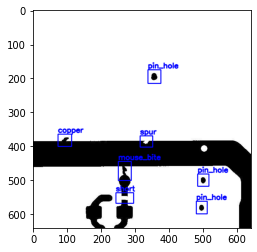

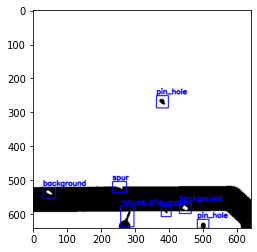

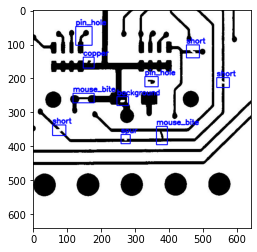

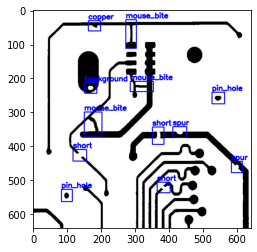

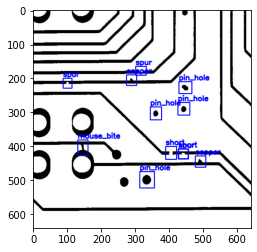

In [ ]:
if __name__ == '__main__':

    tg = createData(TangEtAl)

    nn = createNeuralNetwork(tg.settings,model_name='resnet50_fpn', optim='SGD')

    nn.load()

    nn.test(tg.test_ds)

PCB Dataset dataset created successfully!
        Number of training samples: 519
        Number of validation samples: 130
        Number of test samples: 44
        Authors: Huang e Wei
        Article: A PCB Dataset for Defects Detection and Classification
        Company: Open Lab on Human Robot Interaction of Peking University

Neural Network successfully created! 
        Model: FASTER RCNN FPN
        Backbone: EFFICIENTNET_B0
        Optimizer: ASGD

Neural Network successfully loaded! 
        Model: Feature Pyramid Network
        Backbone: Resnet50
        Dataset: PCB_DATASET



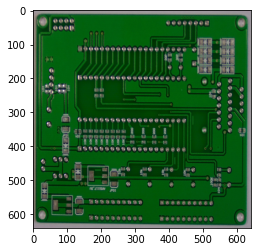

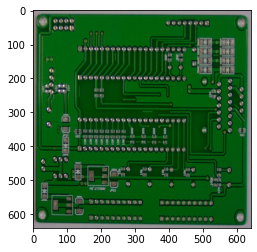

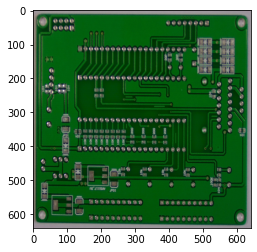

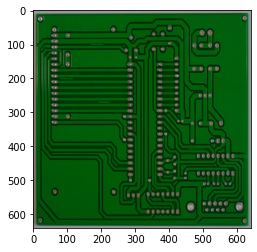

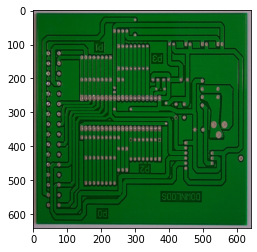

In [ ]:
if __name__ == '__main__':

    hw = createData(HuangWei)

    nn = createNeuralNetwork(hw.settings,model_name='efficientnet_b0', optim='ASGD',  epochs=8)

    nn.load()

    nn.test(hw.test_ds)